## DDQN in Hockey Enviroment - Training

Train a DDQN on various Hockey env. modes

Base DQN implementation adapted from HW7

In [8]:
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import DDQN.DDQN as ddqn
from DDQN.DDQN import DDQNAgent
from DDQN.trainer import Stats, Round, train_ddqn_agent
import hockey.hockey_env as h_env


reload(h_env)
reload(ddqn)

<module 'DDQN.DDQN' from '/home/kivanc/ders/RL/project/RL-Hockey/DDQN/DDQN.py'>

In [9]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

## Training

### Environment & Agent Initialization

In [10]:
env = h_env.HockeyEnv(mode=h_env.Mode.NORMAL)

In [11]:
DISCOUNT = 0.90
EPS = 0.2
UPDATE_TARGET_FREQ = 20
TAU = 1e-3

agent_player = DDQNAgent(
    env.observation_space,
    env.discrete_action_space,
    discount=DISCOUNT,
    epsilon=EPS,
    update_target_freq=UPDATE_TARGET_FREQ,
    tau=TAU
)

agent_opp_weak = h_env.BasicOpponent(weak=True)
agent_opp_strong = h_env.BasicOpponent(weak=False)

In [12]:
# For the visualisation of the training progress
stats = Stats()

### Training

In [13]:
rounds = [
    Round(300, agent_opp_weak),
    Round(600, agent_opp_strong),
    Round(100, agent_opp_weak)
]

train_ddqn_agent(
    agent_player,
    env,
    max_steps=1000,
    rounds=rounds,
    stats=stats,
    ddqn_iter_fit=64,
    print_freq=100,
    tqdm=tqdm,
    verbose=True
)

Begin round 1 for 300 episodes


  0%|          | 0/300 [00:00<?, ?it/s]

Episode 1 | Return: -14.643596781800056 | Loss: 0.004095138981938362 | Done in 183 steps
Episode 101 | Return: -11.228479725080836 | Loss: 0.001995968632400036 | Done in 48 steps
Episode 201 | Return: -10.820472746379282 | Loss: 0.0022313925437629223 | Done in 50 steps
Episode 300 | Return: 9.075294684676951 | Loss: 0.003490367904305458 | Done in 40 steps
Begin round 2 for 600 episodes


  0%|          | 0/600 [00:00<?, ?it/s]

Episode 1 | Return: -11.839207642138495 | Loss: 0.004992046393454075 | Done in 38 steps
Episode 101 | Return: 8.222574721267955 | Loss: 0.011065281927585602 | Done in 99 steps
Episode 201 | Return: -13.791162589597286 | Loss: 0.0025696491356939077 | Done in 100 steps
Episode 301 | Return: -6.833482742294501 | Loss: 0.10346280038356781 | Done in 251 steps
Episode 401 | Return: -10.701451332817792 | Loss: 0.00568696903064847 | Done in 37 steps
Episode 501 | Return: -11.71278756435554 | Loss: 0.014582350850105286 | Done in 251 steps
Episode 600 | Return: -12.743220055129882 | Loss: 0.028689425438642502 | Done in 62 steps
Begin round 3 for 100 episodes


  0%|          | 0/100 [00:00<?, ?it/s]

Episode 1 | Return: -11.58168652871408 | Loss: 0.00853728037327528 | Done in 115 steps
Episode 100 | Return: -16.778042469557633 | Loss: 0.019127393141388893 | Done in 112 steps


## Agent Model Saving

In [14]:
STATE_PATH = "./DDQN/models/hockey_normal_dev/"

reload(ddqn)

agent_player.save_state(STATE_PATH)

## Visualization

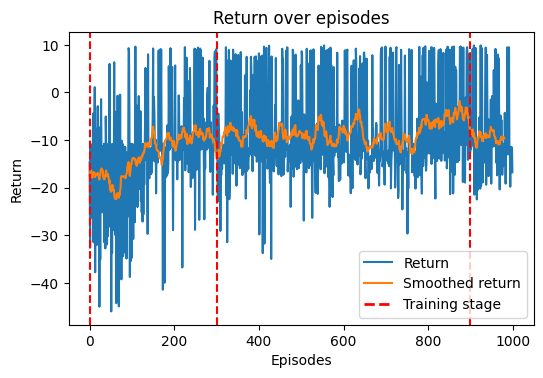

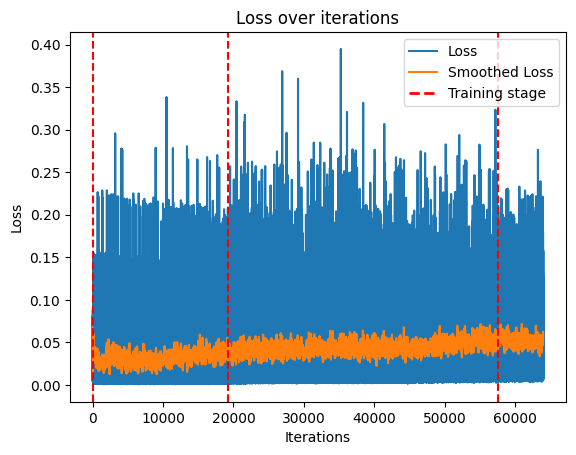

In [15]:
returns_np = np.asarray(stats.returns)
losses_np = np.asarray(stats.losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(returns_np[:,1], label="Return")
plt.plot(running_mean(returns_np[:,1],20), label="Smoothed return")
for xc in stats.returns_training_stages:
    plt.axvline(x=xc, color='r', linestyle='--')
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.title("Return over episodes")
plt.plot([0], color='r', linestyle='--', lw=2, label='Training stage')  # Dummy plot for legend
plt.legend()
plt.show()

plt.figure()
plt.plot(losses_np, label="Loss")
plt.plot(running_mean(losses_np, 50), label="Smoothed Loss")
for xc in stats.losses_training_stages:
    plt.axvline(x=xc, color='r', linestyle='--')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss over iterations")
plt.plot([0], color='r', linestyle='--', lw=2, label='Training stage')  # Dummy plot for legend
plt.legend()
plt.show()

### Rendered Demonstration Against Strong Opponent

For a more detailed evaluation, refer to `ddqn-hockey-eval.ipynb`.

In [ ]:
obs_buffer = []
reward_buffer = []
obs, _ = env.reset()
obs_opp = env.obs_agent_two()

done = False
trunc = False
step = 0
while not (done or trunc):
    step += 1
    env.render()
    
    a1_discr = agent_player.act(obs)
    a1 = env.discrete_to_continous_action(a1_discr)
    a2 = agent_opp_strong.act(obs_opp)

    obs, r, done, trunc, _ = env.step(np.hstack([a1, a2]))
    obs_buffer.append(obs)
    reward_buffer.append(r)

    obs_opp = env.obs_agent_two()

    if done or trunc:
        print(f"Episode done in {step} steps")
        break

Episode done in 250 steps


In [54]:
env.close()